In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

## config(kernel使うときに変更すべき変数)

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"


## データ加工部

## 画像処理部

__version__

__ver1__<br>
train_concat&メタデータ込み：CV:0.974, LB:????<br>
__ver2__<br>
256*256：CV:0.885, LB:0.890<br>
__verSN:1__<br>
metaval:resizeのみ<br>
192_192：OOF: 0.869 Wall time:  1h 33min LB: 0.861<br>
224_224：OOF: 0.883 Wall time:  2h 07min LB: 0.862<br>
256_256：OOF: 0.875 Wall time:  2h 36min LB: 0.882<br>
382_382：OOF: 0.869 Wall time:  5h 10min LB: 0.854<br>
512_512：OOF: 0.848 Wall time: 10h 29min LB: 0.852<br>

In [3]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description→学習に使わない
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        #self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        #meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            #X_data_np = np.array(x)
            #print("transfor前")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            x = self.transforms(x)
            
        if self.train:
            y = self.df.loc[index]['target']
            #return (x, meta), y
            #print(y)
            #X_data_np = np.array(x)
            #print("transform後")
            #print(X_data_np.shape)
            #y_data_np = np.array(y)
            #print(y_data_np.shape)
            return x, y
        else:
            #return (x, meta), y
            return x
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        #self.meta = nn.Sequential(nn.Linear(500),
        #                          nn.BatchNorm1d(500),
        #                          nn.ReLU(),
        #                          nn.Dropout(p=0.2),
        #                          nn.Linear(500, 250),  # FC layer output will have 50 features
        #                          nn.BatchNorm1d(250),
        #                          nn.ReLU(),
        #                          nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        cnn_features = self.arch(inputs)
        output = self.ouput(cnn_features)
        return output

In [6]:
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [7]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b0 NN architecture
# skf = StratifiedKFold(n_splits=3, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [8]:
def Exec(epochs, model_path, es_patience, TTA, bat_size):
    train_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
    test_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'test.csv')
    metaval_df = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'metaval.csv')
    test = MelanomaDataset(df=test_df,
                           imfolder = SIIM_ISIC_Melanoma_Classification + "pad_jpg/test/" + model_name, 
                           train=False,
                           transforms=test_transform)
    metaval = MelanomaDataset(df=metaval_df,
                              imfolder = SIIM_ISIC_Melanoma_Classification + "pad_jpg/metaval/" + model_name, 
                              train=False,
                              transforms=test_transform)
    oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
    
    # We stratify by target value, thus, according to sklearn StratifiedKFold documentation
    # We can fill `X` with zeroes of corresponding length to use it as a placeholder
    # since we only need `y` to stratify the data
    # for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
    for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
        print('=' * 20, 'Fold', fold, '=' * 20)
        
        best_val = None  # Best validation score within this fold
        patience = es_patience  # Current patience counter
        arch = EfficientNet.from_pretrained('efficientnet-b1')
        model = Net(arch=arch)  # New model for each fold
        model = model.to(device)
        
        
        optim = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
        criterion = nn.BCEWithLogitsLoss()
        
        train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True),  
                                imfolder = SIIM_ISIC_Melanoma_Classification + train_folder, 
                                train=True, 
                                transforms=train_transform)
        val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True),  
                                imfolder = SIIM_ISIC_Melanoma_Classification + train_folder, 
                                train=True, 
                                transforms=test_transform)
    
        train_loader = DataLoader(dataset=train, batch_size=bat_size[0], shuffle=True, num_workers=2)
        val_loader = DataLoader(dataset=val, batch_size=bat_size[1], shuffle=False, num_workers=2)
        test_loader = DataLoader(dataset=test, batch_size=bat_size[2], shuffle=False, num_workers=2)
        metaval_loader = DataLoader(dataset=metaval, batch_size=bat_size[3], shuffle=False, num_workers=2)
        
        del train, val
        gc.collect()
        
        for epoch in range(epochs):
            start_time = time.time()
            correct = 0
            epoch_loss = 0
            model.train()
            
            for x, y in train_loader:
                x = torch.tensor(x, device=device, dtype=torch.float32)
                y = torch.tensor(y, device=device, dtype=torch.float32)
                
                
                optim.zero_grad()
                z = model(x)
                loss = criterion(z, y.unsqueeze(1))
                loss.backward()
                optim.step()
                pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
                correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
                epoch_loss += loss.item()
    
                
            train_acc = correct / len(train_idx)
    
            model.eval()  # switch model to the evaluation mode
            val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
            with torch.no_grad():  # Do not calculate gradient since we are only predicting
                # Predicting on validation set
                for j, (x_val, y_val) in enumerate(val_loader):
                    x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
                    y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                    z_val = model(x_val)
                    val_pred = torch.sigmoid(z_val)
                    val_preds[j*x_val.shape[0]:j*x_val.shape[0] + x_val.shape[0]] = val_pred
                val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
                val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
                
                print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
                epoch + 1, 
                epoch_loss, 
                train_acc, 
                val_acc, 
                val_roc, 
                str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
                
                scheduler.step(val_roc)
                # During the first iteration (first epoch) best validation is set to None
                if not best_val:
                    best_val = val_roc  # So any validation roc_auc we have is the best one for now
                    torch.save(model, model_path)  # Saving the model
                    continue
                    
                if val_roc >= best_val:
                    best_val = val_roc
                    patience = es_patience  # Resetting patience since we have new best validation accuracy
                    torch.save(model, model_path)  # Saving current best model
                else:
                    patience -= 1
                    if patience == 0:
                        print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                        break
        
        del train_loader, x, y
        gc.collect()
        
        model = torch.load(model_path)  # Loading best model of this fold
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        test_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test set
        metaval_preds = torch.zeros((len(metaval), 1), dtype=torch.float32, device=device)  # Predictions for metaval set
        with torch.no_grad():
            # Predicting on validation set once again to obtain data for OOF
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val = torch.tensor(x_val, device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*x_val.shape[0]:j*x_val.shape[0] + x_val.shape[0]] = val_pred
            oof[val_idx] = val_preds.cpu().numpy()
            del val_loader, x_val, y_val
            gc.collect()
            
            #test,metaval両方作る。
            # Predicting on test set
            for _ in range(TTA):
                for i, x_test in enumerate(test_loader):
                    x_test = torch.tensor(x_test, device=device, dtype=torch.float32)
                    z_test = model(x_test)
                    z_test = torch.sigmoid(z_test)
                    test_preds[i*x_test.shape[0]:i*x_test.shape[0] + x_test.shape[0]] += z_test
            test_preds /= TTA
            del test_loader, x_test, z_test
            gc.collect()
            
            # Predicting on metaval set
            for _ in range(TTA):
                for i, x_metaval in enumerate(metaval_loader):
                    x_metaval = torch.tensor(x_metaval, device=device, dtype=torch.float32)
                    z_metaval = model(x_metaval)
                    z_metaval = torch.sigmoid(z_metaval)
                    metaval_preds[i*x_metaval.shape[0]:i*x_metaval.shape[0] + x_metaval.shape[0]] += z_metaval
            metaval_preds /= TTA
            del metaval_loader, x_metaval, z_metaval
            gc.collect()
        
    test_preds /= skf.n_splits
    metaval_preds /= skf.n_splits
    
    print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))
    
    return test_preds, metaval_preds

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 57.264 | Train acc: 0.981 | Val acc: 0.979 | Val roc_auc: 0.794 | Training time: 0:01:55
Epoch 002: | Loss: 46.855 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.869 | Training time: 0:01:53
Epoch 003: | Loss: 45.619 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.864 | Training time: 0:01:50
Epoch 004: | Loss: 43.696 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.863 | Training time: 0:01:50
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 39.880 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.890 | Training time: 0:01:50
Epoch 006: | Loss: 36.595 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.890 | Training time: 0:01:50
Epoch 007: | Loss: 34.082 | Train acc: 0.983 | Val acc: 0.978 | Val roc_auc: 0.883 | Training time: 0:01:50
Epoch     7: reducing learning rate of group 0 to 4.0000e-05.
Epoch 008: | Loss: 29.740

100%|██████████| 279k/279k [00:04<00:00, 57.6kB/s] 


CPU times: user 1h 13min 22s, sys: 20min 20s, total: 1h 33min 43s
Wall time: 1h 33min 55s


Successfully submitted to SIIM-ISIC Melanoma Classification

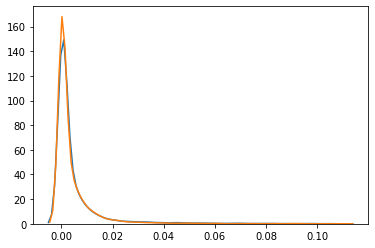

In [9]:
%%time
#192_192
model_name = "192_192"
train_folder = "pad_jpg/train/" + model_name
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16, 16]

test_preds, metaval_preds = Exec(epochs, model_path, es_patience, TTA, bat_size)


sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.cpu().numpy().reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_' + model_name + '.csv', index=False)

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval.csv')
metaval_ID['target'] = metaval_preds.cpu().numpy().reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_' + model_name + '.csv'
message = 'Imgprocessing ' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 55.812 | Train acc: 0.981 | Val acc: 0.979 | Val roc_auc: 0.821 | Training time: 0:02:21
Epoch 002: | Loss: 46.053 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.855 | Training time: 0:02:22
Epoch 003: | Loss: 45.218 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.860 | Training time: 0:02:21
Epoch 004: | Loss: 43.501 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.877 | Training time: 0:02:21
Epoch 005: | Loss: 43.246 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.799 | Training time: 0:02:21
Epoch 006: | Loss: 43.083 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.877 | Training time: 0:02:22
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.
Epoch 007: | Loss: 37.520 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.882 | Training time: 0:02:22
Epoch 008: | Loss: 35.996 | Train acc: 0.983 | Val acc: 0.978 | Val roc_auc: 0.896 | Tr

100%|██████████| 282k/282k [00:03<00:00, 79.2kB/s]


CPU times: user 1h 36min 49s, sys: 30min 48s, total: 2h 7min 38s
Wall time: 2h 7min 43s


Successfully submitted to SIIM-ISIC Melanoma Classification

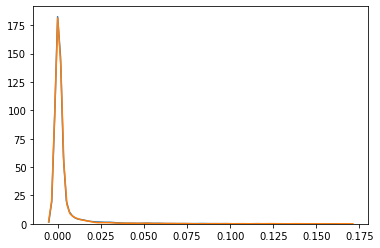

In [10]:
%%time
#224_224
model_name = "224_224"
train_folder = "pad_jpg/train/" + model_name
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16, 16]

test_preds, metaval_preds = Exec(epochs, model_path, es_patience, TTA, bat_size)


sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.cpu().numpy().reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_' + model_name + '.csv', index=False)

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval.csv')
metaval_ID['target'] = metaval_preds.cpu().numpy().reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_' + model_name + '.csv'
message = 'Imgprocessing ' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 57.706 | Train acc: 0.981 | Val acc: 0.979 | Val roc_auc: 0.828 | Training time: 0:02:57
Epoch 002: | Loss: 48.436 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.827 | Training time: 0:02:57
Epoch 003: | Loss: 46.392 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.859 | Training time: 0:02:57
Epoch 004: | Loss: 46.253 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.882 | Training time: 0:02:57
Epoch 005: | Loss: 43.338 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.885 | Training time: 0:02:56
Epoch 006: | Loss: 44.389 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.860 | Training time: 0:02:56
Epoch 007: | Loss: 42.838 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.858 | Training time: 0:02:56
Epoch     7: reducing learning rate of group 0 to 2.0000e-04.
Epoch 008: | Loss: 38.355 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.890 | Tr

100%|██████████| 281k/281k [00:06<00:00, 46.6kB/s]


CPU times: user 1h 55min 37s, sys: 40min 32s, total: 2h 36min 9s
Wall time: 2h 36min 12s


Successfully submitted to SIIM-ISIC Melanoma Classification

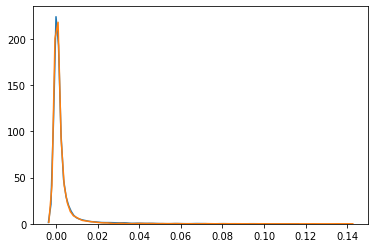

In [11]:
%%time
#256_256
model_name = "256_256"
train_folder = "pad_jpg/train/" + model_name
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [32, 16, 16, 16]

test_preds, metaval_preds = Exec(epochs, model_path, es_patience, TTA, bat_size)


sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.cpu().numpy().reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_' + model_name + '.csv', index=False)

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval.csv')
metaval_ID['target'] = metaval_preds.cpu().numpy().reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_' + model_name + '.csv'
message = 'Imgprocessing ' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 112.166 | Train acc: 0.982 | Val acc: 0.979 | Val roc_auc: 0.833 | Training time: 0:06:31
Epoch 002: | Loss: 101.949 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.850 | Training time: 0:06:32
Epoch 003: | Loss: 101.055 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.845 | Training time: 0:06:32
Epoch 004: | Loss: 96.759 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.672 | Training time: 0:06:32
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.
Epoch 005: | Loss: 87.256 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.881 | Training time: 0:06:39
Epoch 006: | Loss: 84.401 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.888 | Training time: 0:06:40
Epoch 007: | Loss: 83.760 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.892 | Training time: 0:06:35
Epoch 008: | Loss: 82.112 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.894 |

100%|██████████| 279k/279k [00:03<00:00, 78.1kB/s]


CPU times: user 4h 5min 58s, sys: 1h 27min 12s, total: 5h 33min 11s
Wall time: 5h 33min 21s


Successfully submitted to SIIM-ISIC Melanoma Classification

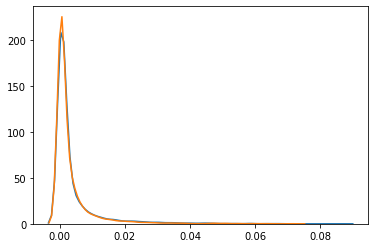

In [12]:
%%time
#384_384
model_name = "384_384"
train_folder = "pad_jpg/train/" + model_name
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [16, 8, 8, 8]

test_preds, metaval_preds = Exec(epochs, model_path, es_patience, TTA, bat_size)


sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.cpu().numpy().reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_' + model_name + '.csv', index=False)

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval.csv')
metaval_ID['target'] = metaval_preds.cpu().numpy().reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_' + model_name + '.csv'
message = 'Imgprocessing ' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
Epoch 001: | Loss: 232.254 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.769 | Training time: 0:11:37
Epoch 002: | Loss: 214.981 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.683 | Training time: 0:11:38
Epoch 003: | Loss: 208.762 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.798 | Training time: 0:11:38
Epoch 004: | Loss: 210.426 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.817 | Training time: 0:11:39
Epoch 005: | Loss: 202.407 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.835 | Training time: 0:11:39
Epoch 006: | Loss: 200.659 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.821 | Training time: 0:11:39
Epoch 007: | Loss: 193.263 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.847 | Training time: 0:11:39
Epoch 008: | Loss: 194.068 | Train acc: 0.983 | Val acc: 0.979 | Val roc_auc: 0.866 | Training time: 0:11:39
Epoch 009: | Loss: 188.013 | Trai

100%|██████████| 279k/279k [00:02<00:00, 95.5kB/s] 


CPU times: user 7h 48min 5s, sys: 2h 42min 4s, total: 10h 30min 9s
Wall time: 10h 29min 27s


Successfully submitted to SIIM-ISIC Melanoma Classification

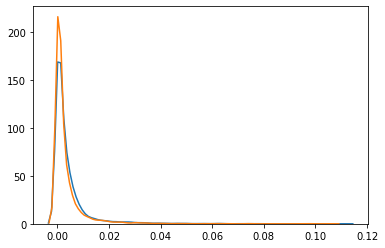

In [13]:
%%time
#512_512
model_name = "512_512"
train_folder = "pad_jpg/train/" + model_name
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [8, 4, 4, 4]

test_preds, metaval_preds = Exec(epochs, model_path, es_patience, TTA, bat_size)


sns.kdeplot(pd.Series(test_preds.cpu().numpy().reshape(-1,)));
sns.kdeplot(pd.Series(metaval_preds.cpu().numpy().reshape(-1,)));

#test用
test_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_submission.csv')
test_ID['target'] = test_preds.cpu().numpy().reshape(-1,)
test_ID.to_csv(Output + 'test/sub_test_' + model_name + '.csv', index=False)

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval.csv')
metaval_ID['target'] = metaval_preds.cpu().numpy().reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_' + model_name + '.csv', index=False)

#test用submit
api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'test/sub_test_' + model_name + '.csv'
message = 'Imgprocessing ' + model_name
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

In [16]:
%%time
#768_768
model_name = "768_768"
train_folder = "pad_jpg/train/" + model_name
TestOrMetaval = "metaval" #"test" or "metaval"
epochs = 10  # Number of epochs to run
model_path =  Output + 'model/model_' + model_name + '.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
bat_size = [16, 8, 8]

preds = Exec(epochs, model_path, es_patience, TTA, TestOrMetaval, bat_size)
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

#metaval用
metaval_ID = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval.csv')
metaval_ID['target'] = preds.cpu().numpy().reshape(-1,)
metaval_ID.to_csv(Output + 'metaval/sub_metaval_' + model_name + '.csv', index=False)

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1


RuntimeError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 7.80 GiB total capacity; 6.29 GiB already allocated; 81.50 MiB free; 6.42 GiB reserved in total by PyTorch)

## TableDataモデル部


__version__

__ver1__<br>
ハイパーパラメータ実装&train_concat：CV:0.8992, LB:0.642<br>
__ver2__<br>
train使用&isnul廃止：CV:0.6942 LB:0.642<br>
__ver3__<br>
patient_id使用：CV:0.7164 LB:0.653<br>
__ver4__<br>
train使用&isnul使用：CV:0.7194 LB:0.653<br>
__ver5__<br>
 "subsample_freq": 1,"subsample": 0.9：CV:0.7274 LB:0.664<br>

__verSN:1__<br>
patientid有、isnan有<br>
lgb: CV mean score: 0.7306, std: 0.0175.<br>

__initialize__

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import os

In [2]:
# config
melanoma_external_malignant_256 = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/melanoma_external_malignant_256/"
SIIM_ISIC_Melanoma_Classification = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/SIIM-ISIC-Melanoma-Classification/"
Output = "/home/tidal/ML_Data/SIIM-ISIC_Melanoma_Classification/Output/"

In [3]:
#train_concatとtestに被るデータはない。
train_TD = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'train.csv')
train_TD = train_TD.drop(['diagnosis','benign_malignant'], axis=1)
test_TD  = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'metaval.csv')
sub_TD   = pd.read_csv(SIIM_ISIC_Melanoma_Classification + 'sample_sub_metaval.csv')

train_TD.shape, test_TD.shape, sub_TD.shape

((24811, 6), (8315, 8), (8315, 2))

In [4]:
#patient_id 削除
#train_TD = train_TD.drop(['patient_id'], axis=1)
#test_TD = test_TD.drop(['patient_id'], axis=1)

__preprocessing__

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
#ラベルエンコード(文字列→数値)
def Label_encode(train, test, feature_name):
    for f in feature_name:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
    
    return train, test

In [7]:
def FillnaAndInsertIsnan(DataFrame, ColsAndFillVals):
    for (col, val) in ColsAndFillVals:
        IsnanSeries = DataFrame[col].isnull()
        DataFrame[col] = DataFrame[col].fillna(val)
        DataFrame.insert(len(DataFrame.columns), col + "_isnan", IsnanSeries)
    return DataFrame

In [8]:
mean_age_approx = train_TD['age_approx'].mean()
train_TD = FillnaAndInsertIsnan(train_TD, [('sex','na'), ('age_approx',mean_age_approx), ('anatom_site_general_challenge','na')])
test_TD = FillnaAndInsertIsnan(test_TD, [('sex','na'), ('age_approx',mean_age_approx), ('anatom_site_general_challenge','na')])

In [9]:
train_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0,False,False,False
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0,False,False,False
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0,False,False,False
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0,False,False,False
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0,False,False,False


In [10]:
test_TD.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,ISIC_0452656,IP_3858753,male,35.0,upper extremity,unknown,benign,0,False,False,False
1,ISIC_0507189,IP_3858753,male,40.0,lower extremity,unknown,benign,0,False,False,False
2,ISIC_1144286,IP_3858753,male,40.0,torso,unknown,benign,0,False,False,False
3,ISIC_1199236,IP_3858753,male,40.0,torso,unknown,benign,0,False,False,False
4,ISIC_1303205,IP_3858753,male,40.0,torso,unknown,benign,0,False,False,False


In [11]:
print(train_TD.dropna(how='any').shape)
print(test_TD.dropna(how='any').shape)

(24811, 9)
(8315, 11)


In [12]:
feature_name =  ['image_name','patient_id','sex','anatom_site_general_challenge']
#feature_name =  ['image_name','sex','anatom_site_general_challenge']
train_TD, test_TD = Label_encode(train_TD, test_TD, feature_name)

In [13]:
X = train_TD.drop(['image_name','target'], axis=1)
y = train_TD['target']
X_test = test_TD.drop(['image_name'], axis=1)

In [14]:
X.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,1453,1,45.0,0,False,False,False
1,610,0,45.0,6,False,False,False
2,555,0,50.0,1,False,False,False
3,1374,0,45.0,0,False,False,False
4,1774,0,55.0,6,False,False,False


In [15]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [16]:
X_test.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_isnan,age_approx_isnan,anatom_site_general_challenge_isnan
0,785,1,35.0,6,unknown,benign,0,False,False,False
1,785,1,40.0,1,unknown,benign,0,False,False,False
2,785,1,40.0,5,unknown,benign,0,False,False,False
3,785,1,40.0,5,unknown,benign,0,False,False,False
4,785,1,40.0,5,unknown,benign,0,False,False,False


__model__

In [17]:
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import time
import seaborn as sns
from sklearn.svm import SVC

In [44]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, 
                               plot_feature_importance=False, model=None, verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    :params: verbose - parameters for gradient boosting models
    :params: early_stopping_rounds - parameters for gradient boosting models
    :params: n_estimators - parameters for gradient boosting models
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': 'auc',
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid, num_iteration=model.best_iteration_)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict_proba(X_valid)#.reshape(-1,)
            #print(len(y_pred_valid))
            #print(len(y_valid))
            #print(y_pred_valid)
            #print(y_valid)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1])
            print(f'Fold {fold_n + 1}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        #print(oof.shape)
        #print(oof[valid_index])
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))#0 or 1の問題にしか対応してない

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict


__run__

In [19]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

Fold 1 started at Sat Jul 11 17:42:54 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[87]	training's auc: 0.82674	training's binary_logloss: 0.0792209	valid_1's auc: 0.750999	valid_1's binary_logloss: 0.072215
Fold 2 started at Sat Jul 11 17:42:54 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's auc: 0.909817	training's binary_logloss: 0.0678287	valid_1's auc: 0.707223	valid_1's binary_logloss: 0.076834
Fold 3 started at Sat Jul 11 17:42:55 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[437]	training's auc: 0.941192	training's binary_logloss: 0.0626433	valid_1's auc: 0.750734	valid_1's binary_logloss: 0.0798121
Fold 4 started at Sat Jul 11 17:42:57 2020
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[306]	training's auc: 0.921827	training's binary_logloss

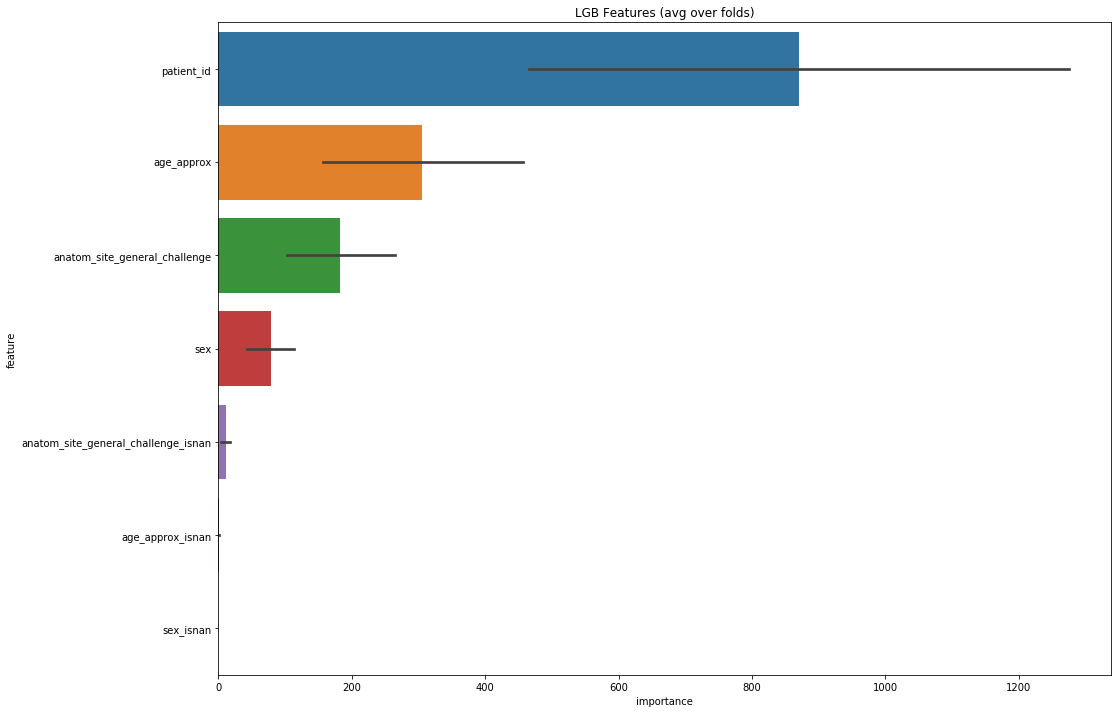

In [22]:
%%time

#交差検証
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
m_type = "lgb"

params = {"boosting_type": "gbdt",
          "learning_rate": 0.01,
          #'max_depth': 7,
          #'num_leaves': 31,
          "subsample_freq": 1,
          "subsample": 0.9,
          #'reg_alpha': 0,
          #'reg_lambda': 0,
         }

#lgb(決定木)で学習実行
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type=m_type, eval_metric='auc',
                                         plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000)

sub_TD.target = result_dict_lgb["prediction"][:,1]
sub_TD.to_csv(Output + 'metaval/sub_metaval_TD_' + m_type + '.csv', index=False)

In [45]:
%%time

#交差検証
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
m_type = "sklearn"

params = None
C = 1
gamma = 'auto'

#support vector machine
model = SVC(C=C, gamma=gamma, probability=True)

result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type=m_type, eval_metric='auc',
                                         plot_feature_importance=True, verbose=1000, early_stopping_rounds=200, n_estimators=10000, model = model)

sub_TD.target = result_dict_lgb["prediction"][:,1]
sub_TD.to_csv(Output + 'metaval/sub_metaval_TD_' + m_type + 'SVC' + '.csv', index=False)

Fold 1 started at Mon Jul 13 06:46:03 2020
Fold 0. auc: 0.6256.

Fold 2 started at Mon Jul 13 06:46:31 2020
Fold 1. auc: 0.6144.

Fold 3 started at Mon Jul 13 06:46:59 2020
Fold 2. auc: 0.7041.

Fold 4 started at Mon Jul 13 06:47:26 2020
Fold 3. auc: 0.6097.

Fold 5 started at Mon Jul 13 06:47:54 2020
Fold 4. auc: 0.6736.

CV mean score: 0.6455, std: 0.0371.
CPU times: user 2min 17s, sys: 204 ms, total: 2min 18s
Wall time: 2min 18s


In [46]:
sub_TD.target = result_dict_lgb["prediction"][:,1]
sub_TD.head(10)

,image_name,target
0,ISIC_0452656,0.017848
1,ISIC_0507189,0.017295
2,ISIC_1144286,0.017221
3,ISIC_1199236,0.017221
4,ISIC_1303205,0.017221
5,ISIC_1321376,0.017221
6,ISIC_1469861,0.017295
7,ISIC_1763257,0.017295
8,ISIC_2005921,0.017221
9,ISIC_2361997,0.017221


In [47]:
sub_TD.shape

(8315, 2)

In [48]:
sub_TD[sub_TD.target == 0]

,image_name,target


In [49]:
#table dataモデルのpred
sub_TD.to_csv(Output + 'metaval/sub_metaval_TD_' + m_type + '.csv', index=False)

#table dataモデルのみの投稿(基本はコメントアウトすること。)
#sub_TD.to_csv(Output + 'submission.csv', index=False)


## Ensemble(Meta model)部

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
image_sub = pd.read_csv(Output + 'submission_ID.csv')
tabular_sub = pd.read_csv(Output + 'submission_TD.csv')
tabular_sub.head()

,image_name,target
0,ISIC_0052060,0.054598
1,ISIC_0052349,0.035829
2,ISIC_0058510,0.009064
3,ISIC_0073313,0.008289
4,ISIC_0073502,0.006654


In [41]:
sub = image_sub.copy()
sub.target = 0.9 * image_sub.target.values + 0.1 * tabular_sub.target.values
sub.to_csv(Output + 'submission.csv', index=False)

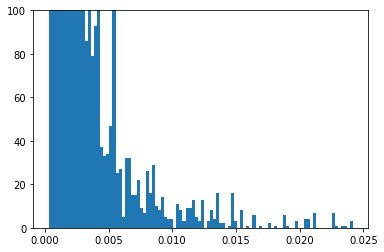

In [42]:
plt.hist(sub.target,bins=100)
plt.ylim((0,100))
plt.show()

## Submit(ここより先はkernelで入れなくて良い)

In [17]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()  # 認証を通す
csv_file_path = Output + 'submission.csv'
message = 'lgb (table only)'
competition_id = 'siim-isic-melanoma-classification'
api.competition_submit(csv_file_path, message, competition_id)

100%|██████████| 277k/277k [00:04<00:00, 57.6kB/s] 


Successfully submitted to SIIM-ISIC Melanoma Classification